In [15]:
%reset -f

In [16]:
# Import data

import pandas as pd

# Load the first Excel file
df1 = pd.read_csv('embeddingsLarge_LargeResponseSet.csv',header = None)

X = df1.T

In [ ]:
# Perform model reduction using the SVD

import numpy as np

# Perform SVD
U, Sigma, VT = np.linalg.svd(X)

print("U matrix:")
print(U)
print("\nSigma values:")
print(Sigma)
print("\nV^T matrix:")
print(VT)


In [ ]:
# Look at the decay of the singular values

import matplotlib.pyplot as plt

plt.plot(np.log(Sigma/np.sum(Sigma)),'o-')

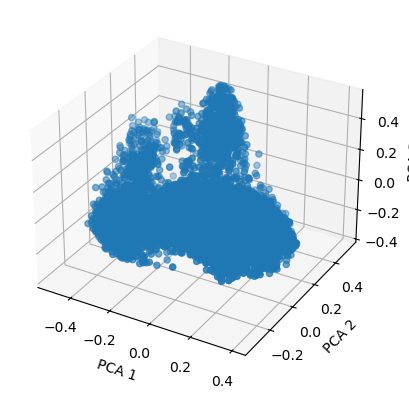

In [19]:
# Projecting the data onto the first three principal components and visualizing

from mpl_toolkits.mplot3d import Axes3D

Y = np.dot(U.T,X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting data
ax.scatter(Y[1,:], Y[2,:], Y[3,:])

# Setting labels
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Display the plot
plt.show()

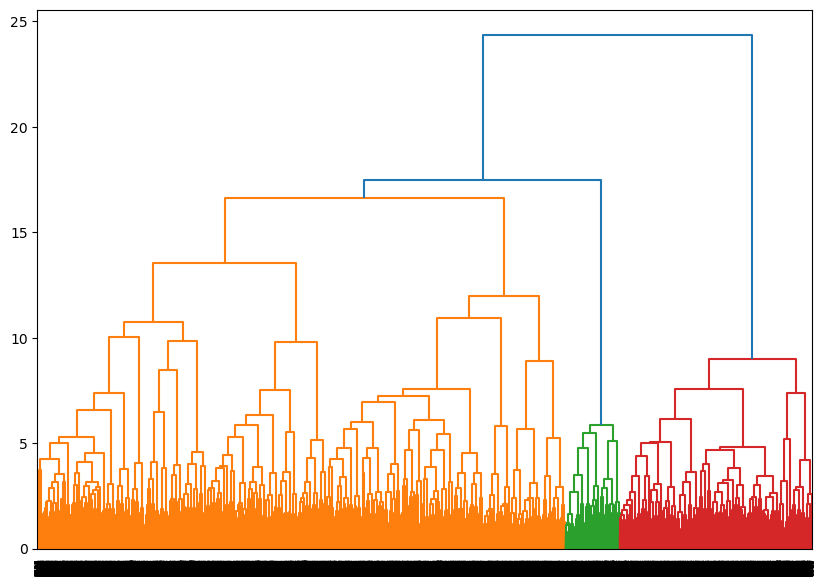

In [20]:
# Performing a hierarchical clustering of the data.  Why hierarchical clustering?  Because we are interested in the relationships between the data points, not just the data points themselves.

#!pip install scikit-learn

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

Data = Y.T
numOfModes = 250

# Perform hierarchical/agglomerative clustering
linked = linkage(Data[:,:numOfModes], 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()


In [21]:
# Different ways to determine a cutoff distance or number of clusters

from scipy.cluster.hierarchy import fcluster

# Determine clusters at a specific cutoff distance
# Replace 'cutoff_distance' with your chosen distance
cutoff_distance = 0.1  # Example value; adjust based on your dendrogram
clusters = fcluster(linked, cutoff_distance, criterion='distance')

# Determine clusters for a specific number of clusters
# Replace 'num_clusters' with your desired number of clusters
num_clusters = 50  # Example value; adjust as needed
clusters_at_level = fcluster(linked, num_clusters, criterion='maxclust')

print("Cluster assignments at cutoff distance:", clusters)
print("Cluster assignments for specific number of clusters:", clusters_at_level)


Cluster assignments at cutoff distance: [6706   64 2078 ... 1011 2809 4535]
Cluster assignments for specific number of clusters: [41  1 10 ...  5 16 27]


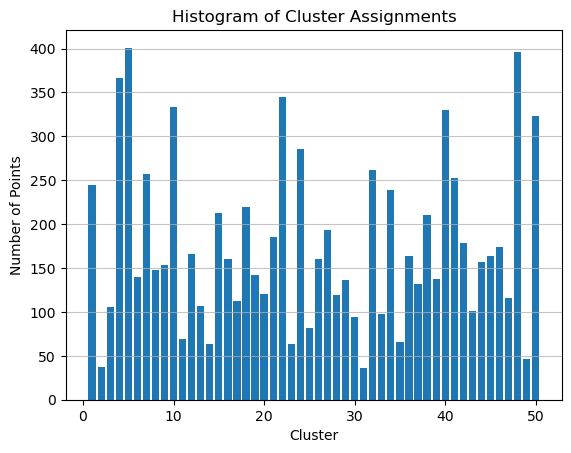

In [22]:
import matplotlib.pyplot as plt

# Assuming clusters_at_level contains your cluster assignments
# Example: clusters_at_level = fcluster(linked, 5, criterion='maxclust')

# Create a histogram of the cluster assignments
plt.hist(clusters_at_level, bins=range(1, max(clusters_at_level)+2), align='left', rwidth=0.8)

# Label the axes
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.title('Histogram of Cluster Assignments')

# Optional: Add grid for easier visualization
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()



In [ ]:
# Add the cluster assignments to the original data

import csv
from io import StringIO

with open('ecv_reasons_novx 1.csv', 'r', encoding='utf-8', errors='ignore') as file:
    content = file.read()

# Assuming 'content' is your CSV file content as a string
content_io = StringIO(content)

# Create a CSV DictReader object
reader = csv.DictReader(content_io)

rows = list(reader)

print(rows[6]['reason'])

In [25]:
# This creates a file for responses in each cluster.  This will then be fed into the next step of the process which is passing to an LLM for interpretation.

for index in range(1,51):

    TestResponses = np.where(clusters_at_level == index)[0]
    batchStrings = [rows[index]['reason'] for index in TestResponses]

    # If batchStrings needs to be converted to a DataFrame
    df_to_save = pd.DataFrame(batchStrings)

    # Save the DataFrame to an Excel file
    df_to_save.to_excel('largeEmbeddingOutputsAllDataRed250_50Clusters/textOutput'+str(index)+'.xlsx', index=False, engine='openpyxl')

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

# n_clusters is the number of clusters you want to test

Try = 200
silhouette_avg = np.zeros((Try,1))

for cluster in range(2,Try):
    
    n_clusters = cluster
    # Step 3: Form flat clusters from the linkage matrix
    clusters = fcluster(linked, t=n_clusters, criterion='maxclust')

    # Calculate the Silhouette Coefficient
    silhouette_avg[cluster] = silhouette_score(Data[:,:numOfModes], clusters)

plt.plot(silhouette_avg,'o-')
